# Grocery Cluster

Company XYZ is an online grocery store. In the current version of the website, they have manually grouped the items into a few categories based on their experience.

However, they now have a lot of data about user purchase history. Therefore, they would like to put the data into use! This is what they asked you to do:

The company founder wants to meet with some of the best customers to go through a focus group with them. You are asked to send the ID of the following customers to the founder:

1) The customer who bought the most items overall in her lifetime.

2) For each item, the customer who bought that product the most.

3) Cluster items based on user co-purchase history.

That is, create clusters of products that have the highest probability of being bought together.

The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

Let's start with the analysis now:

# 1.0 Import Libraries

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import re
from collections import Counter
import itertools
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline

# 2.0 Load Data & Data Exploratory

In [2]:
item = pd.read_csv('item_to_id.csv')
item.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [3]:
item['Item_name'].replace('dishwashing\xa0', 'dishwashing', inplace=True)

In [4]:
pur = pd.read_csv('purchase_history.csv')
pur.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [5]:
print("Unique users:", len(pur['user_id'].unique()))
print("Total number of transaction in purchase history:", len(pur['id']))

Unique users: 24885
Total number of transaction in purchase history: 39474


# 3.0 Data Preperation

## 3.1 Create item dictionary

In [6]:
item_dict = item.set_index('Item_id').to_dict()['Item_name']

In [7]:
print(item_dict.values())

dict_values(['coffee', 'tea', 'juice', 'soda', 'sandwich loaves', 'dinner rolls', 'tortillas', 'bagels', 'canned vegetables', 'spaghetti sauce', 'ketchup', 'cheeses', 'eggs', 'milk', 'yogurt', 'butter', 'cereals', 'flour', 'sugar', 'pasta', 'waffles', 'frozen vegetables', 'ice cream', 'poultry', 'beef', 'pork', 'bananas', 'berries', 'cherries', 'grapefruit', 'apples', 'broccoli', 'carrots', 'cauliflower', 'cucumbers', 'lettuce', 'laundry detergent', 'dishwashing', 'paper towels', 'toilet paper', 'aluminum foil', 'sandwich bags', 'shampoo', 'soap', 'hand soap', 'shaving cream', 'baby items', 'pet items'])


In [8]:
print(item_dict)

{43: 'coffee', 23: 'tea', 38: 'juice', 9: 'soda', 39: 'sandwich loaves', 37: 'dinner rolls', 34: 'tortillas', 13: 'bagels', 28: 'canned vegetables', 26: 'spaghetti sauce', 41: 'ketchup', 21: 'cheeses', 14: 'eggs', 16: 'milk', 48: 'yogurt', 8: 'butter', 11: 'cereals', 30: 'flour', 1: 'sugar', 31: 'pasta', 5: 'waffles', 22: 'frozen vegetables', 36: 'ice cream', 6: 'poultry', 17: 'beef', 47: 'pork', 46: 'bananas', 40: 'berries', 25: 'cherries', 20: 'grapefruit', 32: 'apples', 44: 'broccoli', 10: 'carrots', 45: 'cauliflower', 42: 'cucumbers', 2: 'lettuce', 18: 'laundry detergent', 27: 'dishwashing', 24: 'paper towels', 33: 'toilet paper', 15: 'aluminum foil', 7: 'sandwich bags', 12: 'shampoo', 35: 'soap', 29: 'hand soap', 19: 'shaving cream', 4: 'baby items', 3: 'pet items'}


## 3.2 Split item id column with ","

In [9]:
item_arr = []
for i in range(len(pur)):
    item_arr.append(pur['id'].loc[i].split(','))
# item_arr

## 3.3 Map shopping-cart item_ids to item_names

In [10]:
final_arr =[]
for i in range(len(item_arr)):
    temp_arr = []
    temp_arr = item_arr[i]
    for i in range(len(temp_arr)):
        temp_arr[i]  = item_dict[int(temp_arr[i])]
    final_arr.append(temp_arr)

In [11]:
purchase_user_arr = pur['user_id']

## 3.4 Create dataframe of user_id and purchase item 

In [12]:
user_to_item = []
for i in range(len(final_arr)):
    temp_arr = []
    temp_arr = final_arr[i]
    for j in range(len(temp_arr)):
        user_to_item.append([purchase_user_arr[i], temp_arr[j]])

In [13]:
user_item_df = pd.DataFrame(user_to_item, columns=['user_id', 'item_name'])
user_item_df.head()

,user_id,item_name
0,222087,dishwashing
1,222087,spaghetti sauce
2,1343649,poultry
3,1343649,pork
4,1343649,beef


## 3.5 Create pivot_table for finding correlation between items

In [14]:
user_item_df['bought']=1
user_item_df.head(3)

,user_id,item_name,bought
0,222087,dishwashing,1
1,222087,spaghetti sauce,1
2,1343649,poultry,1


In [15]:
user_item_pivot = user_item_df.pivot_table(index=['user_id'], columns=['item_name'], values='bought')
user_item_pivot.head(3)

item_name,aluminum foil,apples,baby items,bagels,bananas,beef,berries,broccoli,butter,canned vegetables,...,shaving cream,soap,soda,spaghetti sauce,sugar,tea,toilet paper,tortillas,waffles,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
47,1.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
113,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [16]:
user_item_pivot.fillna(0, inplace=True)

In [17]:
user_item_pivot.to_csv('user_item_pivot.csv')

In [18]:
user_item = pd.read_csv('user_item_pivot.csv')

In [19]:
items = user_item.iloc[:, 1:49]
items.head()

,aluminum foil,apples,baby items,bagels,bananas,beef,berries,broccoli,butter,canned vegetables,...,shaving cream,soap,soda,spaghetti sauce,sugar,tea,toilet paper,tortillas,waffles,yogurt
0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## 3.6 Modify the table with correlation matrix

In [20]:
item_corr = items.corr()
item_corr.head()

,aluminum foil,apples,baby items,bagels,bananas,beef,berries,broccoli,butter,canned vegetables,...,shaving cream,soap,soda,spaghetti sauce,sugar,tea,toilet paper,tortillas,waffles,yogurt
aluminum foil,1.000000,0.061678,0.047728,0.064905,0.067114,0.071278,0.055401,0.072599,0.071912,0.065412,...,0.045270,0.036808,0.071673,0.059981,0.070864,0.062613,0.133057,0.070844,0.034712,0.048195
apples,0.061678,1.000000,0.062212,0.087139,0.225915,0.095325,0.223348,0.087706,0.084418,0.077379,...,0.070087,0.065698,0.089582,0.079165,0.102892,0.083509,0.070139,0.086649,0.055191,0.074820
baby items,0.047728,0.062212,1.000000,0.071940,0.074922,0.070992,0.076462,0.063789,0.064575,0.048423,...,0.050868,0.048610,0.058916,0.045073,0.118216,0.064678,0.058797,0.068229,0.053431,0.063001
bagels,0.064905,0.087139,0.071940,1.000000,0.077304,0.087987,0.093777,0.084959,0.092361,0.082148,...,0.075134,0.066404,0.091899,0.079857,0.097317,0.091047,0.060387,0.251497,0.051933,0.087520
bananas,0.067114,0.225915,0.074922,0.077304,1.000000,0.082479,0.219283,0.093150,0.076063,0.084400,...,0.069899,0.067265,0.092232,0.082774,0.102371,0.091121,0.072508,0.094638,0.065618,0.073154


# 4.0 K-mean Clustering

## 4.1 Determine the ideal number of clusters for a k-means clustering of grocery data

In [21]:
# rule of thoumb
np.sqrt(len(item_corr)/2)

4.898979485566356

(1, 15.65)

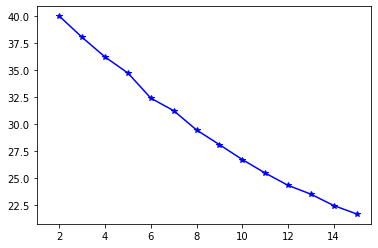

In [22]:
# elbow
from sklearn import metrics

cost = []
for k in range(2,16):
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=10)
    k_means.fit(item_corr)
    cost.append(k_means.inertia_)

fig, ax = plt.subplots()
plt.plot(range(2,16), cost, 'b*-')
plt.xlim(1, plt.xlim()[1])

(1, 15.65)

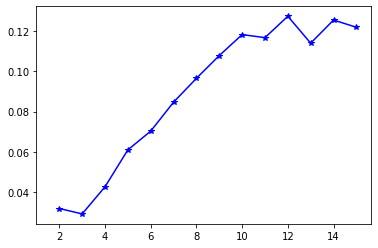

In [23]:
cost = []
for k in range(2,16):
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=10)
    k_means.fit(item_corr)
    cost.append(metrics.silhouette_score(item_corr, k_means.labels_))

# kIdx = np.argmax(cost)
fig, ax = plt.subplots()
plt.plot(range(2,16), cost, 'b*-')
plt.xlim(1, plt.xlim()[1])

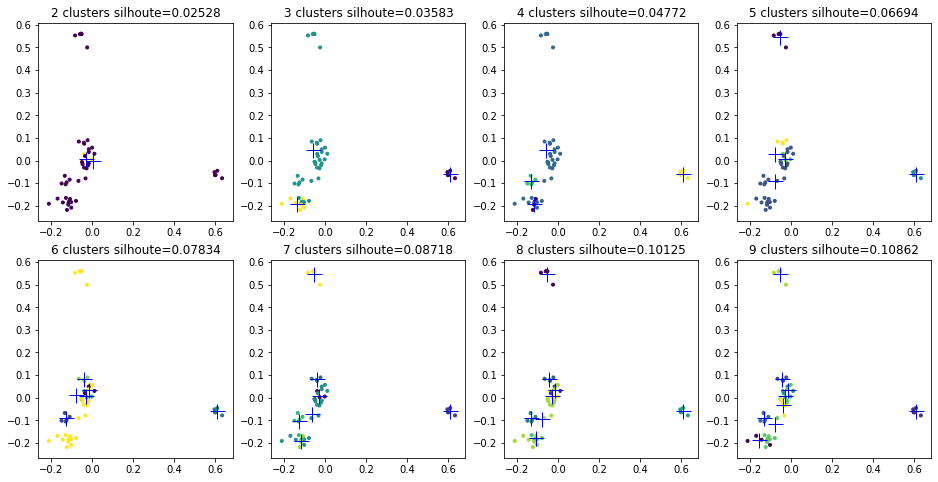

In [34]:
pca = PCA(n_components=2).fit(item_corr)
data2d = pca.transform(item_corr)

plt.figure(figsize=(16, 8))
scores, n_clusters, preds = [], [], []
for i in range(2, 10):
    kmean = KMeans(n_clusters = i).fit(item_corr)
    scores.append(kmean.score(item_corr))
    n_clusters.append(i)
    pred = kmean.predict(item_corr)
    preds.append(pred)
    plt.subplot(2, 4, i - 1)
    plt.title(f"{i} clusters silhoute={np.round(silhouette_score(item_corr, pred), decimals=5)}")
    plt.scatter(data2d[:, 0], data2d[:, 1], c=pred, marker = '.')
    
    centroids = kmean.cluster_centers_
    centroids2d = pca.transform(centroids)
    plt.plot(centroids2d[:, 0], centroids2d[:, 1], 'b+', markersize=15)

## This part is under construction...

In [25]:
pca = PCA()
# rotate by PCA, making it easier to be visualized later
items_rotated = pca.fit_transform(item_corr)

In [ ]:
#items rotated contains the same information as item_item_similarity just that the previous variables have been shifted using PCA components

items_rotated = pd.DataFrame(items_rotated, index=user_item_pivot.index, columns=["pc{}".format(index+1) for index in range(0,item_to_id.shape[0])])



In [27]:
#function to plot clusters using pc1 and pc2 pca components on 2D

def show_clusters(items_rotated,labels):
   
    #plot and print clustering result
    fig = plt.figure(figsize=(15, 10))

    #endless cycle iterator
    colors =  itertools.cycle (["b","g","r","c","m","y","k"])
    print('Labels are :', end = ' ')
    print(labels)
    grps = items_rotated.groupby(labels)
    i = 1
    for label,grp in grps:
      plt.scatter(grp.pc1,grp.pc2,c=next(colors),label = label)
      print('Cluster:', end = ' ')
      print(i)
      i = i+1
      print('\n')
      names = item_to_id.loc[grp.index,"item_name"]
      for index, name in enumerate(names):
        print(index+1,name)
      print('\n')  

     #annotate
    for itemid in items_rotated.index:
      x = items_rotated.loc[itemid,"pc1"]
      y = items_rotated.loc[itemid,"pc2"]
      name = item_to_id.loc[itemid,"item_name"]
      name = re.sub('\W', ' ', name)
      plt.text(x,y,name)
      plt.tight_layout()

      plt.legend(loc="best")

In [28]:
#function that takes in number of clusters and calls the plot function to plot the clusters

def cluster(n_clusters,n_components=48):
  
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(items_rotated.values[:, :])
   
    # display results on a plot
    show_clusters(items_rotated, kmeans.labels_)

In [29]:
cluster(n_clusters=10)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

# 5.0 Hierarchical Clustering

In [42]:
item_corr['cluster'] = model.labels_
item_corr.head()

,aluminum foil,apples,baby items,bagels,bananas,beef,berries,broccoli,butter,canned vegetables,...,soap,soda,spaghetti sauce,sugar,tea,toilet paper,tortillas,waffles,yogurt,cluster
aluminum foil,1.000000,0.061678,0.047728,0.064905,0.067114,0.071278,0.055401,0.072599,0.071912,0.065412,...,0.036808,0.071673,0.059981,0.070864,0.062613,0.133057,0.070844,0.034712,0.048195,0
apples,0.061678,1.000000,0.062212,0.087139,0.225915,0.095325,0.223348,0.087706,0.084418,0.077379,...,0.065698,0.089582,0.079165,0.102892,0.083509,0.070139,0.086649,0.055191,0.074820,1
baby items,0.047728,0.062212,1.000000,0.071940,0.074922,0.070992,0.076462,0.063789,0.064575,0.048423,...,0.048610,0.058916,0.045073,0.118216,0.064678,0.058797,0.068229,0.053431,0.063001,0
bagels,0.064905,0.087139,0.071940,1.000000,0.077304,0.087987,0.093777,0.084959,0.092361,0.082148,...,0.066404,0.091899,0.079857,0.097317,0.091047,0.060387,0.251497,0.051933,0.087520,0
bananas,0.067114,0.225915,0.074922,0.077304,1.000000,0.082479,0.219283,0.093150,0.076063,0.084400,...,0.067265,0.092232,0.082774,0.102371,0.091121,0.072508,0.094638,0.065618,0.073154,1


In [43]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [44]:
model = AgglomerativeClustering(n_clusters=3)
model = model.fit(item_corr)
item_corr['cluster'] = model.labels_

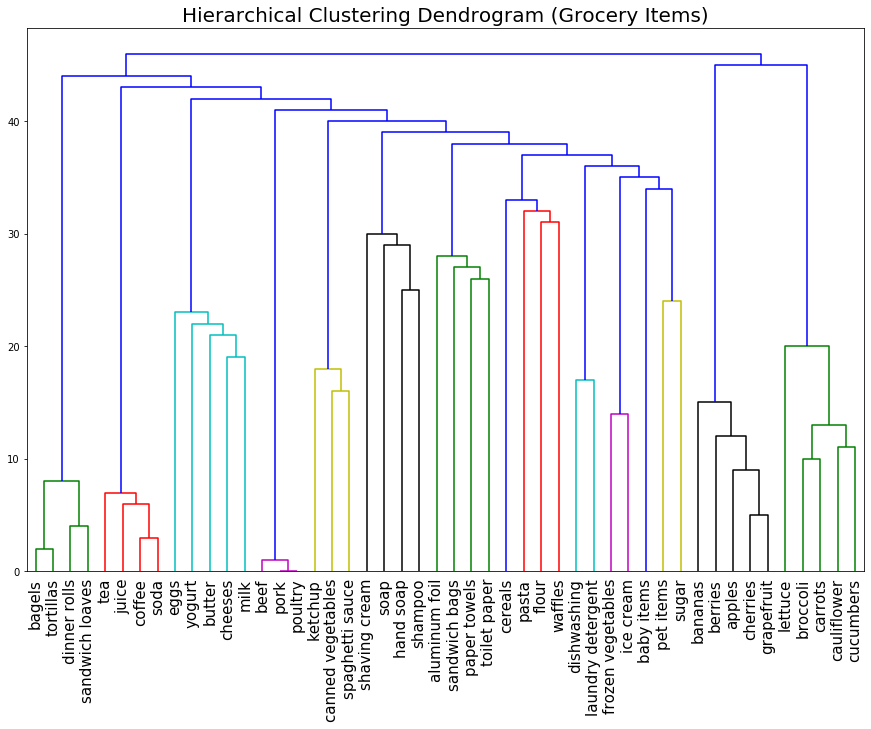

In [50]:
plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram (Grocery Items)', size=20)
plot_dendrogram(model,labels=item_corr.index.values)
plt.xticks(rotation=90, size=15)
# plt.savefig('items.pdf',format='pdf')
plt.show()